In [1]:
%matplotlib inline
import platform
print(platform.python_version())
from ROOT import TFile,vector
import ROOT

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import math 

from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2

from scipy.interpolate import interp1d
from scipy.integrate import quad

from textwrap import wrap
import copy

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

3.5.2
Welcome to JupyROOT 6.14/08


In [2]:
# davios functions for plotting...
  
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
#     wgt = df['OscWeights'].values
    wgt = df['xsec_corr_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    wgt[wgt >= 2] = 2
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt


class sampHist:

    def __init__(self,samp_df,samp_l,samp_c,samp_wind,samp_s):
        self._df = samp_df.copy()
        self._label = samp_l
        self._color = samp_c
        self._scale = samp_s
        self._wi = samp_wind
        if samp_wind == 0:
            self._wgt = np.ones(len(samp_df))
        if samp_wind == 1:
            self._wgt = CV(samp_df)

    def setweight(self,windex):
        if windex == 0:
            self._wgt = np.ones(len(self._df))
        if windex == 1:
            self._wgt = CV(self._df)

    def dist(self,s_var):
        return self._df[s_var].values

    def cosdist(self,s_var):
        return np.cos(self._df[s_var].values)

    def applycut(self,s_cut):
        newhist = copy.deepcopy(self)
        newhist._df = self._df.query(s_cut)
        newhist.setweight(self._wi)
        return newhist

class SimpleHisto:

    def __init__ (self,df_df,f_scale,i_wgt,s_color,s_label):
        temp_df = df_df.copy()
        temp_df['myscale'] = f_scale
        self.mydf = temp_df
        self.mycolor = s_color
        self.mylabel = s_label
        self.iwgt = i_wgt

        self.mycut = 'Enu_1e1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def ClearCut(self):
        self.mycut = 'Enu_1e1p > 0'

    def GetHist(self,s_varname):
        temp_df = self.mydf.query(self.mycut)
        if self.iwgt == 1:
            myweight = CV(temp_df)
        elif self.iwgt == 0:
            myweight = np.ones(len(temp_df))
        return temp_df[s_varname].values,myweight,temp_df['myscale'].values,self.mycolor,self.mylabel

def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high

class StackedHisto:

    def  __init__ (self,a_df_mc,a_df_scale):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layeriwgt = []
        self.stratxweight = []

        temp_a_df = []
        for i in range(len(a_df_mc)):
            temp_df = a_df_mc[i].copy()
            temp_df['myscale'] = a_df_scale[i]
            temp_a_df.append(temp_df)
        self.mymc = pd.concat(temp_a_df)
        self.mycut ='Enu_1e1p > 0'


    def ClearCut(self):
        self.mycut = 'Enu_1e1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def AddLayer(self,df_layer,df_scale,i_wgt,s_label,s_color):
        temp_df = df_layer.copy()
        temp_df['myscale'] = df_scale
        self.mylayer.append(temp_df)
        self.layerlabel.append(s_label)
        self.layercolor.append(s_color)
        self.layeriwgt.append(i_wgt)

    def AddStrata(self,s_strata,s_label,s_color,f_wgt=1.0):
        self.mystrata.append(s_strata)
        self.stratalabel.append(s_label)
        self.stratacolor.append(s_color)
        self.stratxweight.append(f_wgt)

    def GetHists(self,s_varname):
        a_vals = []        # (nxN)
        a_wgts = []
        a_scale = []
        a_cols = []        # (nx1)
        a_labels = []

        # first, run  through strata
        for i in range(len(self.mystrata)):
            # isolate this stratum with current cut
            temp_df = self.mymc.query(self.mystrata[i]+' and '+self.mycut)

            a_vals.append(temp_df[s_varname].values)
            a_wgts.append(CV(temp_df) * self.stratxweight[i])   # ah, this is if we want to scale an individual stratum
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.stratacolor[i])
            a_labels.append(self.stratalabel[i])

        for i in range(len(self.mylayer)):
            temp_df = self.mylayer[i].query(self.mycut)

            a_vals.append(temp_df[s_varname].values)
            if self.layeriwgt[i] == 1:
                a_wgts.append(CV(temp_df))
            elif self.layeriwgt[i] == 0:
                a_wgts.append(np.ones(len(temp_df)))
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.layercolor[i])
            a_labels.append(self.layerlabel[i])

        return  np.asarray(a_vals),np.asarray(a_wgts),np.asarray(a_scale),a_cols,a_labels

    def ClearLayers(self):
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layerwgt = []

    def ClearStrata(self):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []


class distVar:

    def __init__(self,s_name,n_range,s_label='',s_cov=''):
        self.myname = s_name
        self.myrange = n_range
        self.myscov = s_cov
        if s_label == '':
            self.mylabel = s_name
        else:
            self.mylabel = s_label
            
def PmuGivenX(mu,x):

    # Returns the probability density value that the true mean is mu given that you
    # have observed x events. Actually employs a series approximation because the real formula
    # involves a very very large numerator and denominator and overflows even high precision
    # variables if your bins contain more than a few hundred events
    # Approximation is good to O(0.1%) or better at all values

    pi  = np.pi
    c   = [1.,-1./12,1./288,139./51840,-571./2488320,-163879./209018880]

    if x == 0:
        return np.exp(-mu)
    else:
        poly = sum(c[i]/x**(i+0.5) for i in range(len(c)))
        return 1/np.sqrt(2*pi)*np.exp(x+x*np.log(mu/x)-mu)*poly


def distplot_wratio_davio(myvar,nbins,myrange,stackedhists,datahist,stxcoord,m_cov,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #consFac is new and consolidates all MC strata whose contribution is less than a given percent threshold.
    # (my legend was too full of useless stuff)

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    data_vals,data_wgt,data_scale,_,data_label = datahist.GetHist(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


    vals_data_raw,_ = np.histogram(data_vals,nbins,range=myrange,weights=data_wgt)
    vals_data,_ = np.histogram(data_vals,nbins,range=myrange,weights=np.multiply(data_wgt,data_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    #jarretbars
    a_obslo = []
    a_obshi = []
    for i in range(nbins):
        obslo,obshi = GetErrorsData(vals_data[i])
        a_obshi.append(obshi-vals_data[i])
        a_obslo.append(vals_data[i]-obslo)

    #m_cov is fractional, so we multiply it by MC
    for i in range(nbins):
        for j in range(nbins):
            if(vals_mc[i] > 0 and vals_mc[j] > 0):
                m_cov[i][j] *= vals_mc[i]*vals_mc[j]
            else:
                m_cov[i][j] = 0

    # Normalization uncertainty:
    fNorm_squared = m_cov.sum() / np.power(vals_mc.sum(),2)
    print('Normalization Uncertainty:',np.sqrt(fNorm_squared))

    yerr_mc_sys = np.sqrt(np.diag(m_cov))
    yerr_mc_total = np.sqrt(np.diag(m_cov) + yerrsq_mc)

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_mc_raw[i] > 0:
            ndof += 1
            if vals_data[i] > 0:
                yerrsq_data[i] += (3.0*vals_data[i]*vals_mc[i]*normshift)/(vals_mc[i]*normshift+2.0*vals_data[i])
            else:
                yerrsq_data[i] += vals_mc[i]*normshift/2.0
            m_cov[i][i] += yerrsq_data[i] + yerrsq_mc[i]
        else:
            m_cov[i][i] += 999

    yerr_data = np.sqrt(yerrsq_data)

    er_rat_line = np.zeros(nbins)
    er_rat_line_sys = np.zeros(nbins)
    er_rat_dotshi = np.zeros(nbins)
    er_rat_dotslo = np.zeros(nbins)

    for i in range(nbins):
        if vals_mc[i] > 0:
            er_rat_line[i] = yerr_mc_total[i]/float(vals_mc[i])
            er_rat_line_sys[i] = yerr_mc_sys[i]/float(vals_mc[i])
            er_rat_dotshi[i] = a_obshi[i]/float(vals_mc[i])
            er_rat_dotslo[i] = a_obslo[i]/float(vals_mc[i])

    chisq = 0.0
    invcov = np.linalg.inv(m_cov)

    # calc chi2
    for i in range(nbins):
        for j in range(nbins):
            if vals_mc_raw[i] > 0 and vals_mc_raw[j] > 0:
                chisq += (vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j]
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    print(chisq/float(ndof),pval)

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max((vals_data+np.asarray(a_obshi)).max(),(vals_mc+yerr_mc_sys).max())*1.4

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Event Count',fontsize=25)
    ax1.set_ylabel('Data/MC',fontsize=25)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax0.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax0.errorbar(bincenters,vals_data,fmt='o',yerr=(a_obslo,a_obshi),color='black',capsize=5,label=data_label+' (%i)'%vals_data.sum(),markersize=8,zorder=20,elinewidth=2)
    ax0.errorbar(bincenters,vals_data,fmt='o',color='white',zorder=19,markersize=16)

    errboxes_tot = []
    errboxes_sys = []

    for i in range(len(bincenters)):
        rect0 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_sys[i])),binedges[i+1]-binedges[i],yerr_mc_sys[i]*2)
        errboxes_sys.append(rect0)
        rect1 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_total[i])),binedges[i+1]-binedges[i],yerr_mc_total[i]*2)
        errboxes_tot.append(rect1)
    pc_sys = PatchCollection(errboxes_tot,facecolor='red', alpha=.3,hatch='X',edgecolor='white')
    pc_sys_outline = PatchCollection(errboxes_tot,facecolor='none', alpha=.9,hatch='X',edgecolor='white',zorder=11)
    pc_tot = PatchCollection(errboxes_sys,facecolor=None,alpha=.1,hatch='/',zorder=12)
    ax0.add_collection(pc_sys)
    ax0.add_collection(pc_sys_outline)
    ax0.add_collection(pc_tot)
    ax0.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='MC Systematic Error')
    ax0.hist(np.zeros(1),(1,2),facecolor='red', alpha=.3,hatch='X',edgecolor='white',label='MC Sys+Stat Error')
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=2)

    errboxes_rat_tot = []
    errboxes_rat_sys = []
    for i in range(len(er_rat_dotshi)):
        rect0 = Rectangle((binedges[i],1-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes_rat_tot.append(rect0)
        rect1 = Rectangle((binedges[i],1-er_rat_line_sys[i]),binedges[i+1]-binedges[i],er_rat_line_sys[i]*2)
        errboxes_rat_sys.append(rect1)

    pc_rat_tot = PatchCollection(errboxes_rat_tot, facecolor='red', alpha=.3)
    pc_rat_sys = PatchCollection(errboxes_rat_sys, facecolor=None, alpha=.1,hatch='/',zorder=12)
    ax1.add_collection(pc_rat_tot)
    ax1.add_collection(pc_rat_sys)
    ax1.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0)

    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0)
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='maroon',capsize=0,markersize=8,elinewidth=2)

    #ax1.legend(loc='lower right',fontsize=15,frameon=False)

    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f $\pm$ %.2f'%(vals_data.sum()/float(vals_mc.sum()),np.sqrt(fNorm_squared)),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)

    plt.tight_layout()

    return fig,ax0,ax1,pval

In [6]:
NUMU_R1_POT = 4.71579e+20
NUE_R1_POT  = 9.80259e+22
NUMU_LOWE_R1_POT = 1.63103516179e+21
NUE_LOWE_R1_POT = 6.05398370114e+23
DATA_R1_OPEN_POT = 4.403e+19
EXT_R1_OPEN_POT = (22474918.0 / 9776965.0)* DATA_R1_OPEN_POT

NUMU_R3_POT = 8.98773223801e+20
NUE_R3_POT = 4.707047e+22
NUMU_LOWE_R3_POT = 1.51234621011e+21
NUE_LOWE_R3_POT =  4.70704675581e+22

FULLOSC_R1_POT = 2.71612e+20
FULLOSC_R3_POT = 2.74298e+20

HE_C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
print(HE_C1_POT)
HE_D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
HE_E1_POT = 5.923e+19
HE_F1_POT = 4.3e+19
HE_G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17
HE_DAT_POT1 = HE_C1_POT
HE_DAT_POT3 = HE_D2_POT+HE_E1_POT+HE_F1_POT+HE_G1_POT
HIGHE_POT = HE_DAT_POT1 + HE_DAT_POT3

POT_SCALE_FACTOR = 1.0 #if I feel like playing with scaling

# CURRENT TOTAL
# DATA_POT_TOTAL = DATA_R1_PI0FILTER_POT+DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT
# print("total POT: ",DATA_POT_TOTAL)

1.746029e+20


In [7]:
# ADD SCALES HERE
# just doing run 1 for now..
NUMU_R1_SCALE = (POT_SCALE_FACTOR*HE_C1_POT)/ float(NUMU_R1_POT)
NUE_R1_SCALE =  (POT_SCALE_FACTOR*HE_C1_POT)/ float(NUE_R1_POT)
NUMU_LOWE_R1_SCALE = (POT_SCALE_FACTOR*HE_C1_POT)/ float(NUMU_LOWE_R1_POT)
NUE_LOWE_R1_SCALE = (POT_SCALE_FACTOR*HE_C1_POT)/ float(NUE_LOWE_R1_POT)
EXT_R1_OPEN_SCALE =  (POT_SCALE_FACTOR*HE_C1_POT)/ float(EXT_R1_OPEN_POT)
FULLOSC_R1_SCALE = (POT_SCALE_FACTOR*HE_C1_POT)/ float(FULLOSC_R1_POT)

In [10]:
#Load in Pickle files

RSE=['run','subrun','event']

tag = 'Oct_5_run1_numu'
df_numu_r1 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run1_nue'
df_nue_r1 = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run1_ext'
df_ext_r1 = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)

tag = 'Oct_5_run3_numu'
df_numu_r3 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run3_nue'
df_nue_r3 = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run3_ext'
df_ext_r3 = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)

tag = 'Oct_5_run1_lowE_numu'
df_numu_lowE_r1 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run3_lowE_numu'
df_numu_lowE_r3 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run1_lowE_nue'
df_nue_lowE_r1 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run3_lowE_nue'
df_nue_lowE_r3 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

tag = 'Oct_5_run1_fullosc'
df_fullosc_r1 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Oct_5_run3_fullosc'
df_fullosc_r3 = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)

tag ='Oct_5_open_run1'
df_data_open = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag ='Oct_26_run1C_HE'
df_data_HE_1C = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag ='Oct_26_run2D_HE'
df_data_HE_2D = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag ='Oct_26_run2E_HE'
df_data_HE_2E = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag ='Oct_26_run3F_HE'
df_data_HE_3F = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag ='Oct_26_run3G_HE'
df_data_HE_3G = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
print(len(df_data_HE_1C))

61


In [12]:
# apply osc weights to full osc sample
# assume two flavor for now
# page 264 prd, eq 14.54

# parameters: 
m21=2 #MeV 
sin2_2theta_21 = 0.093
L = 470 

# p = sin2_2theta_21*(sin^2((m21/(4*E))*L)) 

# define function
def oscweights(df,sin22):
    weights = []
    m21=2 #MeV 
    L = 470 
    
    for i in range(len(df_fullosc_r1)):
        E=df_fullosc_r1['Enu_true'].values[i]
        sine = sin((m21/(4.0*E)*L))
        P=sin22*(sine**2)
        weights.append(P)
        
return weights
    
    
df_fullosc_r1['OscWeights'] = osc1
df_fullosc_r3['OscWeights'] = osc3

print(osc1)

[0.0017015135711148897, 0.004130264726115983, 0.015323316125802506, 0.023794876952422165, 0.002957170288486344, 0.00025956527252831644, 0.00025956527252831644, 0.00025956527252831644, 0.00025956527252831644, 0.0032281543850552663, 0.002162848399617176, 0.002162848399617176, 0.002162848399617176, 0.002162848399617176, 0.002162848399617176, 0.002162848399617176, 0.002162848399617176, 0.005144977810732002, 0.007576649873696475, 0.007576649873696475, 0.007576649873696475, 0.007576649873696475, 0.002132156261425707, 0.003243199964523384, 0.003243199964523384, 0.008818141392772611, 0.00037319717807691034, 0.00037319717807691034, 0.00037319717807691034, 0.029559728724247846, 0.0034782965054221196, 0.0034782965054221196, 0.0034782965054221196, 0.0031828661533352042, 0.003386072470658627, 0.003386072470658627, 0.005712667489811995, 0.005712667489811995, 0.02396510366552711, 0.02396510366552711, 0.005295192655678288, 0.005295192655678288, 0.002918440071119565, 0.002918440071119565, 0.00848430059

In [48]:
# apply preselection cuts to all data frames

# step_general = 'PassSimpleCuts !=0 and PassShowerReco!=0 and not (TotPE < 20 or PorchTotPE > 20) and good ==1'
# step_1e1p = 'Proton_ThetaReco <= 1.57079 and _pi0mass<=50 and Proton_Edep>= 60 and Electron_Edep >= 35 and MaxShrFrac>=.2 '
# preselection_cuts=step_general+'and '+step_1e1p


# step_general = 'PassSimpleCuts !=0 and PassShowerReco!=0 and not (TotPE < 20 or PorchTotPE > 20) and good ==1'
step_general = 'PassSimpleCuts !=0 and PassShowerReco!=0 and not (TotPE < 20 or PorchTotPE > 20) and good ==1'
# step_1e1p = 'Proton_ThetaReco <= 1.57079 and _pi0mass<=50 and Proton_Edep>= 60 and Electron_Edep >= 35 and MaxShrFrac>=.2'
step_1e1p = 'Proton_ThetaReco <= 1.57079 and _pi0mass<=50 and Proton_Edep>= 60 and Electron_Edep >= 35  and MaxShrFrac>=.2'
preselection_cuts=step_general+'and '+step_1e1p


df_numu_r1_pre = df_numu_r1.query(preselection_cuts)
df_nue_r1_pre = df_nue_r1.query(preselection_cuts)
df_ext_r1_pre = df_ext_r1.query(preselection_cuts)
df_numu_lowE_r1_pre = df_numu_lowE_r1.query(preselection_cuts)
df_nue_lowE_r1_pre = df_nue_lowE_r1.query(preselection_cuts)
df_fullosc_r1_pre = df_fullosc_r1.query(preselection_cuts)
df_data_pre = df_data_open.query(preselection_cuts)
print(len(df_fullosc_r1_pre))

df_numu_r3_pre = df_numu_r3.query(preselection_cuts)
df_nue_r3_pre = df_nue_r3.query(preselection_cuts)
df_ext_r3_pre = df_ext_r3.query(preselection_cuts)
df_numu_lowE_r3_pre = df_numu_lowE_r3.query(preselection_cuts)
df_nue_lowE_r3_pre = df_nue_lowE_r3.query(preselection_cuts)
df_fullosc_r3_pre = df_fullosc_r3.query(preselection_cuts)

13208


In [49]:
# first trying to use the fullosc like data
# first make the MC distributions

# plot lists for all of the seperate distributions
vartest_list = []
varname_list = []
myrange_list = []
detvar_list  = []
sys_list = []
bins_list = []

vartest_list.append('Enu_1e1p')
varname_list.append('Neutrino Energy (MeV)')
myrange_list.append((0,1200.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(12)

369.1738181725649
hstack gh_weights [1.31811002 1.42647664 1.50004578 ... 1.         1.         1.        ]
hstack gh_scale [0.09336718 0.09336718 0.09336718 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
3.0740788000956836 0.0003877803891358944


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:396: RuntimeWarning: invalid value encountered in true_divide


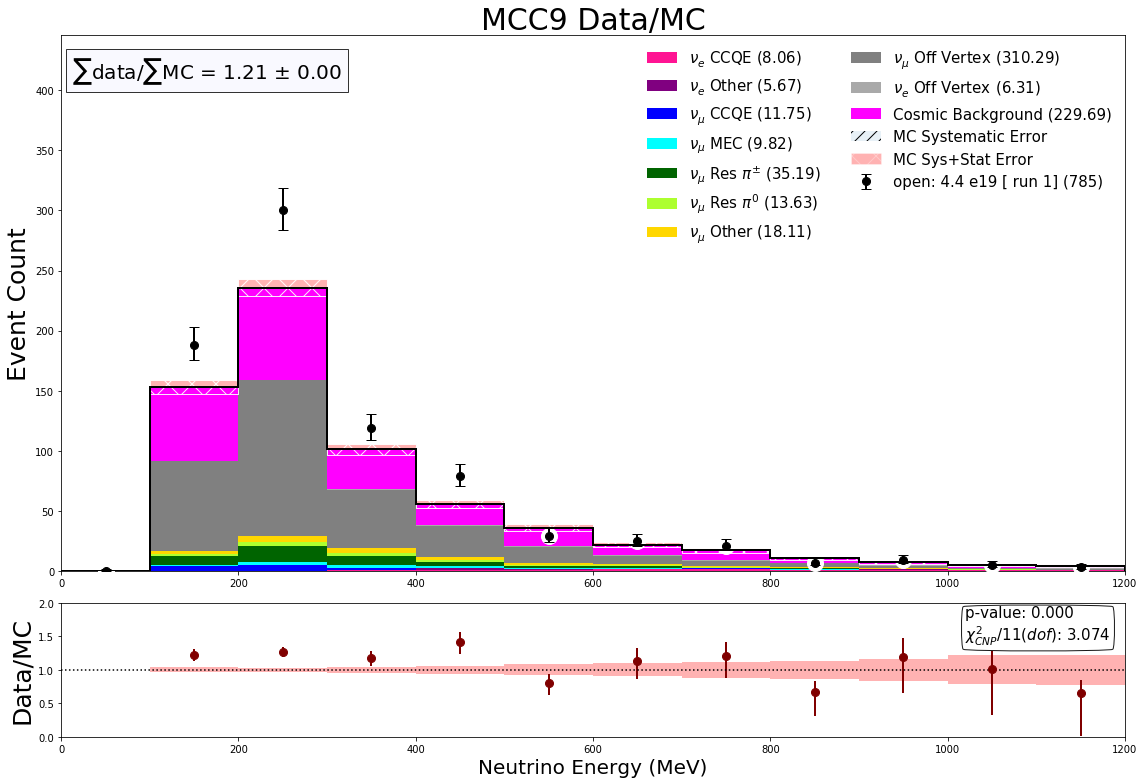

In [50]:
for i in range(len(vartest_list)):
    vartest = vartest_list[i]
    varname = varname_list[i]
    myrange = myrange_list[i]
    nbins =bins_list[i]
    if sys_list[i] =='none':
        s_cov = np.zeros((nbins,nbins))
    else:
        s_cov = np.genfromtxt(sys_list[i],delimiter=',')
    if detvar_list[i] == 'none':
        d_cov = np.zeros((nbins,nbins))
    else:
        d_cov = np.genfromtxt(detvar_list[i],delimiter=',')
    cov = s_cov+d_cov
    print (len(df_numu_r1_pre.query('MC_parentPDG == 14'))*NUMU_R1_SCALE)
    run1Hists = StackedHisto((df_numu_r1_pre.query('MC_energyInit > 400'),df_numu_lowE_r1_pre,df_nue_r1_pre.query('MC_energyInit > 400'),df_nue_lowE_r1_pre),(NUMU_R1_SCALE,NUMU_LOWE_R1_SCALE,NUE_R1_SCALE,NUE_LOWE_R1_SCALE))
#     run1Hists = StackedHisto((df_numu_r1_pre,df_nue_r1_pre),(NUMU_R1_SCALE,NUE_R1_SCALE))
    run1Hists.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_e^{ }$ CCQE','deeppink')
    run1Hists.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type!=1001",r'$\nu_e^{ }$ Other','purple')
    run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_\mu^{ }$ CCQE','blue')
    run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1000",r'$\nu_\mu$ MEC','cyan')
    run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085]",r'$\nu_\mu$ Res $\pi^{\pm}$','darkgreen')
    run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu$ Res $\pi^0$','greenyellow')
    run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type not in [1000,1001,1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085,1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu^{ }$ Other','gold')
    run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr>=5 ",r'$\nu_\mu^{ }$ Off Vertex$_{ }^{ }$','grey')
    run1Hists.AddStrata("MC_parentPDG == 12 and MC_scedr>=5 ",r'$\nu_e^{ }$ Off Vertex$_{ }^{ }$','darkgrey')
    run1Hists.AddLayer(df_ext_r1_pre,EXT_R1_OPEN_SCALE,0,'Cosmic Background','fuchsia')
    run1_FullOsc_Hist = SimpleHisto(df_data_pre,1.0,0,'','open: 4.4 e19 [ run 1]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1Hists,run1_FullOsc_Hist,varname,m_cov=cov)
#     print(FULLOSC_R1_SCALE)
#     run1Hists = StackedHisto((df_fullosc_r1_pre),(FULLOSC_R1_SCALE))
#     run1Hists.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_e^{ }$ CCQE','deeppink')
#     run1Hists.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type!=1001",r'$\nu_e^{ }$ Other','purple')
#     run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_\mu^{ }$ CCQE','blue')
#     run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1000",r'$\nu_\mu$ MEC','cyan')
#     run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085]",r'$\nu_\mu$ Res $\pi^{\pm}$','darkgreen')
#     run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu$ Res $\pi^0$','greenyellow')
#     run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type not in [1000,1001,1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085,1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu^{ }$ Other','gold')
#     run1Hists.AddStrata("MC_parentPDG == 14 and MC_scedr>=5 ",r'$\nu_\mu^{ }$ Off Vertex$_{ }^{ }$','grey')
#     run1Hists.AddStrata("MC_parentPDG == 12 and MC_scedr>=5 ",r'$\nu_e^{ }$ Off Vertex$_{ }^{ }$','darkgrey')
# #     run1Hists.AddLayer(df_ext_r1_pre,EXT_R1_OPEN_SCALE,0,'Cosmic Background','fuchsia')
#     run1_FullOsc_Hist = SimpleHisto(df_data_pre,1.0,0,'','open: 4.4 e19 [ run 1]')
#     fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1Hists,run1_FullOsc_Hist,varname,m_cov=cov)


In [51]:
# apply postselection cuts
selection_cuts = 'BDTscore_1e1p>.7'
print(df_fullosc_r1_pre['BDTscore_1e1p'].values)

df_numu_r1_sel = df_numu_r1_pre.query(selection_cuts)
df_nue_r1_sel = df_nue_r1_pre.query(selection_cuts)
df_ext_r1_sel = df_ext_r1_pre.query(selection_cuts)
df_numu_lowE_r1_sel = df_numu_lowE_r1_pre.query(selection_cuts)
df_nue_lowE_r1_sel = df_nue_lowE_r1_pre.query(selection_cuts)
df_fullosc_r1_sel = df_fullosc_r1_pre.query(selection_cuts)
df_data_sel = df_data_pre.query(selection_cuts)

df_numu_r3_sel = df_numu_r3_pre.query(selection_cuts)
df_nue_r3_sel = df_nue_r3_pre.query(selection_cuts)
df_ext_r3_sel = df_ext_r3_pre.query(selection_cuts)
df_numu_lowE_r3_sel = df_numu_lowE_r3_pre.query(selection_cuts)
df_nue_lowE_r3_sel = df_nue_lowE_r3_pre.query(selection_cuts)
df_fullosc_r3_sel = df_fullosc_r3_pre.query(selection_cuts)

[9.9901897e-01 6.5520406e-03 7.4165261e-01 ... 8.4738576e-01 9.0420246e-04
 2.3966432e-03]


hstack gh_weights [1.31811002 1.42647664 1.50004578 ... 1.         1.         1.        ]
hstack gh_scale [0.09336718 0.09336718 0.09336718 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
1.1500189496690605 0.3168008791752921


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:396: RuntimeWarning: invalid value encountered in true_divide


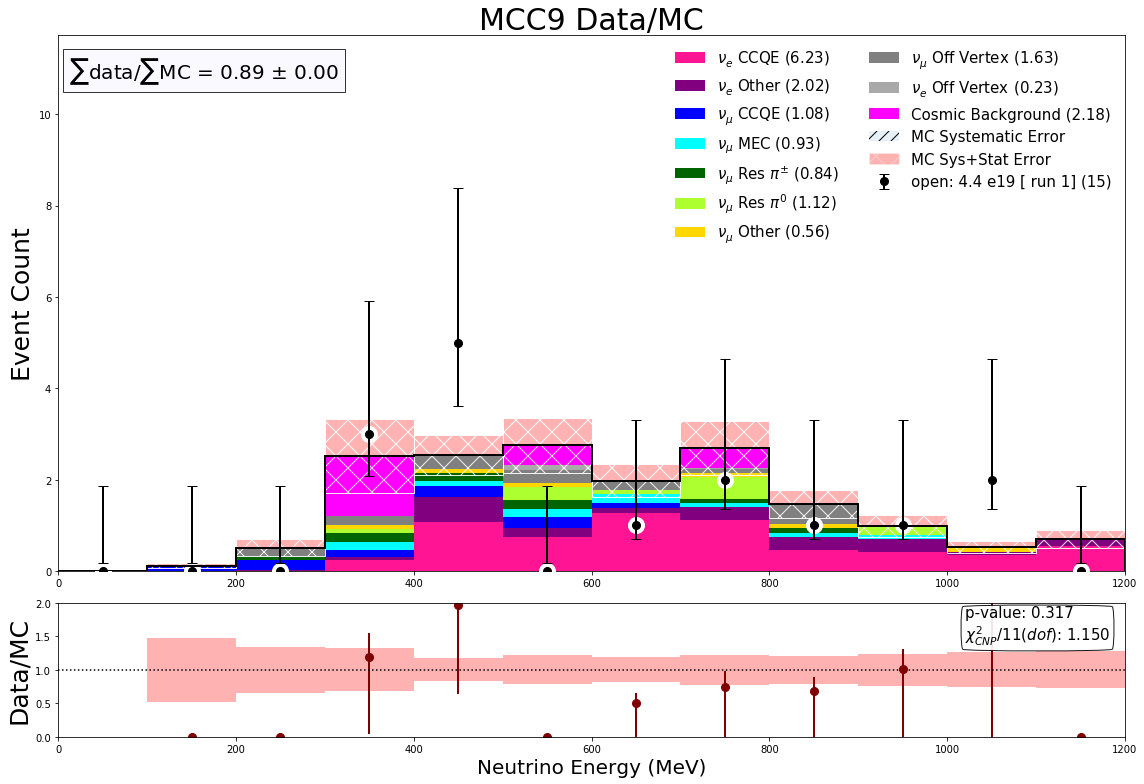

In [44]:
for i in range(len(vartest_list)):
    vartest = vartest_list[i]
    varname = varname_list[i]
    myrange = myrange_list[i]
    nbins =bins_list[i]
    if sys_list[i] =='none':
        s_cov = np.zeros((nbins,nbins))
    else:
        s_cov = np.genfromtxt(sys_list[i],delimiter=',')
    if detvar_list[i] == 'none':
        d_cov = np.zeros((nbins,nbins))
    else:
        d_cov = np.genfromtxt(detvar_list[i],delimiter=',')
    cov = s_cov+d_cov
    run1Hists_sel = StackedHisto((df_numu_r1_sel.query('MC_energyInit > 400'),df_numu_lowE_r1_sel,df_nue_r1_sel.query('MC_energyInit > 400'),df_nue_lowE_r1_sel),(NUMU_R1_SCALE,NUMU_LOWE_R1_SCALE,NUE_R1_SCALE,NUE_LOWE_R1_SCALE))
    run1Hists_sel.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_e^{ }$ CCQE','deeppink')
    run1Hists_sel.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type!=1001",r'$\nu_e^{ }$ Other','purple')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_\mu^{ }$ CCQE','blue')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1000",r'$\nu_\mu$ MEC','cyan')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085]",r'$\nu_\mu$ Res $\pi^{\pm}$','darkgreen')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu$ Res $\pi^0$','greenyellow')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type not in [1000,1001,1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085,1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu^{ }$ Other','gold')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr>=5 ",r'$\nu_\mu^{ }$ Off Vertex$_{ }^{ }$','grey')
    run1Hists_sel.AddStrata("MC_parentPDG == 12 and MC_scedr>=5 ",r'$\nu_e^{ }$ Off Vertex$_{ }^{ }$','darkgrey')
    run1Hists_sel.AddLayer(df_ext_r1_sel,EXT_R1_OPEN_SCALE,0,'Cosmic Background','fuchsia')
    run1_FullOsc_Hist_sel = SimpleHisto(df_data_sel,1.0,0,'','open: 4.4 e19 [ run 1]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1Hists_sel,run1_FullOsc_Hist_sel,varname,m_cov=cov)


In [11]:
df_list = [df_fullosc_r3_sel,df_nue_lowE_r3_sel,df_numu_lowE_r3_sel,df_ext_r3_sel,df_nue_r3_sel,df_numu_r3_sel,df_data_sel,df_fullosc_r1_sel,df_nue_lowE_r1_sel,df_numu_lowE_r1_sel,df_numu_r1_sel,df_nue_r1_sel,df_ext_r1_sel]

def postcuts(df):
    cuts = []
    for idx in range(0,len(df)):
        postcut =0
        pi0 = df['_pi0mass'].values[idx]
        pid = float(df['GammaPID_pix_v'].values[idx][2])/float(df['EminusPID_pix_v'].values[idx][2]+0.0001)
        protontheta = df['Proton_ThetaReco'].values[idx]
        electron = df['Electron_Edep'].values[idx]
        muon = df['MuonPID_int_v'].values[idx][2]
        EU = df['shower1_sumQ_U'].values[idx]*0.0139+31.5
        EV = df['shower1_sumQ_V'].values[idx]*0.0143+35.7
        EY = df['shower1_sumQ_Y'].values[idx]*0.0125+13.8
        shrcons = sqrt((EU-EV)**2 + (EU-EY)**2 + (EY-EV)**2)/EY
        
        if(pid <=2  and (electron <= 100 or muon <= 0.2) and shrcons<=2):
            postcut = 1
            
        cuts.append(postcut)
    return cuts

for df in df_list:
    cuts = postcuts(df)
    df['Pass1e1pPost'] = cuts

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
df_numu_r1_post = df_numu_r1_sel.query("Pass1e1pPost==1")
df_nue_r1_post = df_nue_r1_sel.query("Pass1e1pPost==1")
df_ext_r1_post = df_ext_r1_sel.query("Pass1e1pPost==1")
df_numu_lowE_r1_post = df_numu_lowE_r1_sel.query("Pass1e1pPost==1")
df_nue_lowE_r1_post = df_nue_lowE_r1_sel.query("Pass1e1pPost==1")
df_fullosc_r1_post = df_fullosc_r1_sel.query("Pass1e1pPost==1")
df_data_post = df_data_sel.query("Pass1e1pPost==1")

df_numu_r3_post = df_numu_r3_sel.query("Pass1e1pPost==1")
df_nue_r3_post = df_nue_r3_sel.query("Pass1e1pPost==1")
df_ext_r3_post = df_ext_r3_sel.query("Pass1e1pPost==1")
df_numu_lowE_r3_post = df_numu_lowE_r3_sel.query("Pass1e1pPost==1")
df_nue_lowE_r3_post = df_nue_lowE_r3_sel.query("Pass1e1pPost==1")
df_fullosc_r3_post = df_fullosc_r3_sel.query("Pass1e1pPost==1")

# end by removing duplicates
df_numu_r1_post = df_numu_r1_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_nue_r1_post = df_nue_r1_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_ext_r1_post = df_ext_r1_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()

df_numu_r3_post = df_numu_r3_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_nue_r3_post = df_nue_r3_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_ext_r3_post = df_ext_r3_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()

df_numu_lowE_r1_post = df_numu_lowE_r1_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_numu_lowE_r3_post = df_numu_lowE_r3_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_nue_lowE_r1_post = df_nue_lowE_r1_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_nue_lowE_r3_post = df_nue_lowE_r3_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()

df_fullosc_r1_post = df_fullosc_r1_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()
df_fullosc_r3_post = df_fullosc_r3_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()

df_data_post = df_data_post.sort_values('BDTscore_1e1p',ascending=False).drop_duplicates(RSE).sort_index()

hstack gh_weights [1.31811002 1.42647664 1.50004578 ... 1.33767672 1.         1.54191   ]
hstack gh_scale [9.33671771e-02 9.33671771e-02 9.33671771e-02 ... 4.49167006e-04
 4.49167006e-04 7.27289702e-05]
Normalization Uncertainty: 0.0
0.7312036394820786 0.7094252851384034


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:395: RuntimeWarning: invalid value encountered in true_divide


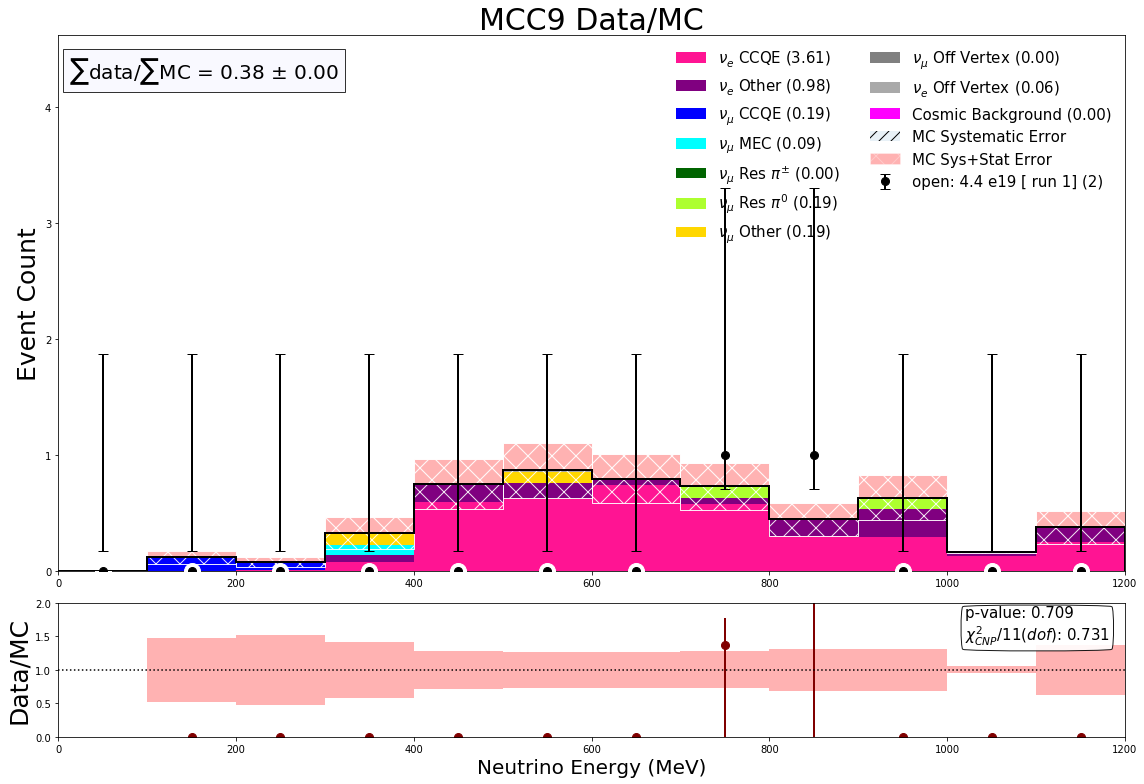

In [13]:
for i in range(len(vartest_list)):
    vartest = vartest_list[i]
    varname = varname_list[i]
    myrange = myrange_list[i]
    nbins =bins_list[i]
    if sys_list[i] =='none':
        s_cov = np.zeros((nbins,nbins))
    else:
        s_cov = np.genfromtxt(sys_list[i],delimiter=',')
    if detvar_list[i] == 'none':
        d_cov = np.zeros((nbins,nbins))
    else:
        d_cov = np.genfromtxt(detvar_list[i],delimiter=',')
    cov = s_cov+d_cov
    run1Hists_sel = StackedHisto((df_numu_r1_post.query('MC_energyInit > 400'),df_numu_lowE_r1_post,df_nue_r1_post.query('MC_energyInit > 400'),df_nue_lowE_r1_post),(NUMU_R1_SCALE,NUMU_LOWE_R1_SCALE,NUE_R1_SCALE,NUE_LOWE_R1_SCALE))
    run1Hists_sel.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_e^{ }$ CCQE','deeppink')
    run1Hists_sel.AddStrata("MC_parentPDG == 12 and MC_scedr<5 and nu_interaction_type!=1001",r'$\nu_e^{ }$ Other','purple')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1001",r'$\nu_\mu^{ }$ CCQE','blue')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type==1000",r'$\nu_\mu$ MEC','cyan')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085]",r'$\nu_\mu$ Res $\pi^{\pm}$','darkgreen')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type in [1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu$ Res $\pi^0$','greenyellow')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr<5 and nu_interaction_type not in [1000,1001,1003,1005,1007,1009,1010,1012,1014,1016,1017,1021,1028,1032,1079,1085,1004,1006,1008,1011,1013,1015,1080,1086,1090]",r'$\nu_\mu^{ }$ Other','gold')
    run1Hists_sel.AddStrata("MC_parentPDG == 14 and MC_scedr>=5 ",r'$\nu_\mu^{ }$ Off Vertex$_{ }^{ }$','grey')
    run1Hists_sel.AddStrata("MC_parentPDG == 12 and MC_scedr>=5 ",r'$\nu_e^{ }$ Off Vertex$_{ }^{ }$','darkgrey')
    run1Hists_sel.AddLayer(df_ext_r1_post,EXT_R1_OPEN_SCALE,0,'Cosmic Background','fuchsia')
    run1_FullOsc_Hist_sel = SimpleHisto(df_data_post,1.0,0,'','open: 4.4 e19 [ run 1]')
    fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1Hists_sel,run1_FullOsc_Hist_sel,varname,m_cov=cov)


In [ ]:
Proton_ThetaReco > 1.57079
_pi0mass<50
PassSimpleCuts ==1
PassShowerReco==1
PassPMTPrecut ==1 
Proton_Edep> 60
Electron_Edep >35
MaxShrFrac>=.2 
